In [1]:
import os
import sys
from tqdm import tqdm
from datetime import date
import random
import pandas as pd
from pathlib import Path
import numpy as np

from one.api import ONE

import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy
from sklearn.metrics import accuracy_score
from torchmetrics import AUROC
from torchmetrics.regression import MeanSquaredError
import lightning as L 
from lightning.pytorch.utilities import CombinedLoader

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)

seed = 666
set_seed(seed)

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 1. use multi-session RRR encoder to learn U and V in 5 regions
# 2. stitch U and V in different sessions to generate simulated X and Y
# 3. use hierarchical RRR decoder to recover V for 5 regions

1. simulate data

In [25]:
# setup
regions = ["LP", "GRN", "PO", "DG", "CA1"]
n_roi = len(regions)
n_sess_per_roi = 5
n_sess = n_roi * n_sess_per_roi
n_rank_V = 2
n_rank_B = 2
in_path = Path("/mnt/3TB/yizi/cached_ibl_data")

In [26]:
Xs, lst_units = [], []

pid_idx = 0
for roi_idx, roi in enumerate(regions):

    f_names = os.listdir(in_path/roi)
    pids = [f_name.split("_")[1].split(".")[0] for f_name in f_names][:n_sess_per_roi]

    print("=================")
    print(f"Loading {len(pids)} PIDs in region {roi}:")
    for pid in pids:
        print(pid)

    for _, pid in enumerate(pids):

        data_dict = np.load(in_path/roi/f"pid_{pid}.npy", allow_pickle=True).item()

        xs = data_dict["neural_contrast"]["all"]
        Xs.append(xs)
        lst_units.append(data_dict["meta"]["n_units"])
        pid_idx += 1

Loading 5 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
Loading 5 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b0c875
c0e59477-43f0-4441-9f81-3a55ddad9dad
df6012d0-d921-4d0a-af2a-2a91030d0f42
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
7332e6cf-9847-4aca-b2e3-d864989dd0fb
Loading 5 PIDs in region PO:
81950362-ed95-4662-997f-e119bbd594d1
77121d92-6dde-4243-ab54-0a99efa22e99
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
4f922a5b-5014-455d-8cd5-7caed78af615
Loading 5 PIDs in region DG:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
49c2ea3d-2b50-4e8a-b124-9e190960784e
c5b9e063-f640-4936-b851-f7602cb6659b
Loading 5 PIDs in region CA1:
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
49

In [27]:
x1 = np.arange(0, 5*np.pi, 0.165)[30:70]
b1 = np.sin(x1)
x2 = np.arange(0, 5*np.pi, 0.165)[10:50]
b2 = np.sin(x2)

In [28]:
x3 = np.arange(0, 5*np.pi, 0.165)[20:60]
b3 = np.sin(x3)
x4 = np.arange(0, 5*np.pi, 0.165)[40:80]
b4 = np.sin(x4)
x5 = np.arange(0, 5*np.pi, 0.165)[55:95]
b5 = np.sin(x5)
B = np.c_[b1, b2]

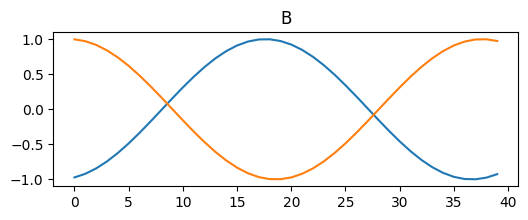

In [29]:
plt.figure(figsize=(6,2))
plt.plot(B)
plt.title("B");

In [30]:
mus = [5, 10, 15, 25, 35]
A = np.zeros((n_roi, n_rank_V, n_rank_B))
for i in range(n_roi):
    mu = np.random.poisson(mus[i])
    A[i] = np.random.normal(mu, size=(n_rank_V, n_rank_B))

In [31]:
V = np.einsum("ijk,tk->ijt", A, B)

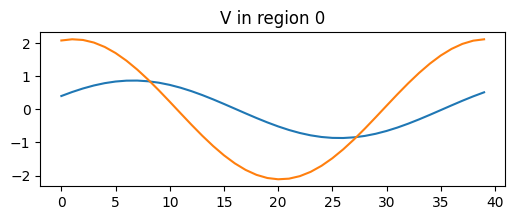

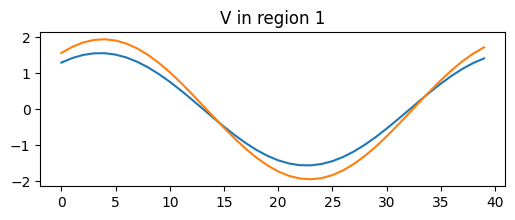

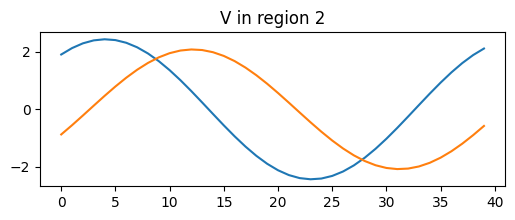

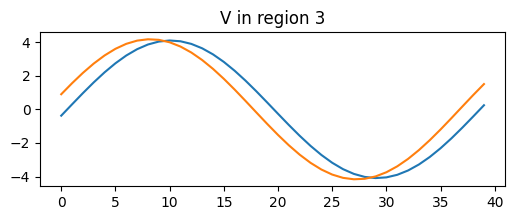

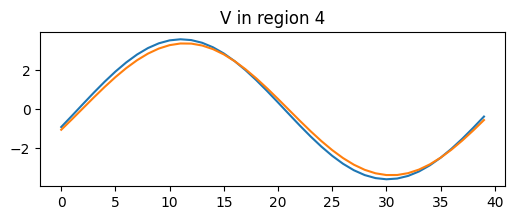

In [32]:
for i in range(n_roi):
    plt.figure(figsize=(6,2))
    plt.plot(V[i].T)
    plt.title(f"V in region {i}");

In [33]:
Us = []
for i in range(n_sess):
    n_unit = lst_units[i]
    U = np.zeros((n_unit, n_rank_V))
    for j in range(n_unit):
        U[j] = np.random.normal(np.random.rand(), size=(n_rank_V,))
    Us.append(U)

In [34]:
lst_sessions = np.arange(n_sess)
lst_regions = np.repeat(np.arange(n_roi), n_sess/n_roi)

In [35]:
bs = []
for i in range(n_sess):
    b = np.random.normal()
    bs.append(b)

In [36]:
from scipy.special import expit

Ys = []
for i in range(n_sess):
    Beta = np.einsum("cr,rt->ct", Us[i], V[lst_regions[i]])
    out = np.einsum("ct,kct->k", Beta, Xs[i]) + bs[i]
    out = expit(out)
    Y = torch.tensor([1 if y > .5 else 0 for y in out]).double()
    Ys.append(Y)

2. use hierarchical RRR decoder to recover V for 5 regions

In [47]:
class SessionDataset:
    def __init__(self, dataset, roi_idx, pid_idx, **kargs):
        self.xs, self.ys = dataset
        self.n_trials, self.n_units, _ = self.xs.shape
        self.roi_idx = roi_idx
        self.pid_idx = pid_idx
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, index):
        return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
    
def dataloader(datasets, roi_idxs, pid_idxs, batch_size=8): 
    loaders = []
    for i, dataset in enumerate(datasets):
        sess_dataset = SessionDataset(dataset, roi_idxs[i], pid_idxs[i])
        loaders.append(DataLoader(
            sess_dataset, 
            batch_size = batch_size,
            shuffle=True, # SHUFFLE
        ))
    return loaders

class Hier_Reduced_Rank_Model(nn.Module):
    def __init__(
        self, 
        n_roi,
        n_units, 
        n_t_bin, 
        rank_V,
        rank_B
    ):
        super(Hier_Reduced_Rank_Model, self).__init__()
        
        self.n_roi = n_roi
        self.n_sess = len(n_units)
        self.n_units = n_units
        self.n_t_bin = n_t_bin
        self.rank_V = rank_V
        self.rank_B = rank_B
        
        self.Us = nn.ParameterList(
            [nn.Parameter(torch.randn(self.n_units[i], self.rank_V)) for i in range(self.n_sess)]
        )
        self.A = nn.Parameter(torch.randn(self.n_roi, self.rank_V, self.rank_B)) 
        self.B = nn.Parameter(
            torch.randn(self.rank_B, self.n_t_bin)
        ) 
        self.intercepts = nn.ParameterList(
            [nn.Parameter(torch.randn(1,)) for i in range(self.n_sess)]
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, dataset):
        X, Y, roi_idx, sess_idx = dataset
        roi_idx = torch.unique(roi_idx)
        sess_idx = torch.unique(sess_idx)
        n_trials, n_units, n_t_bins = X.shape
        self.Vs = torch.einsum("ijk,kt->ijt", self.A, self.B)
        self.Beta = torch.einsum("cr,rt->ct", self.Us[sess_idx], self.Vs[roi_idx].squeeze()).to(DEVICE)
        out = torch.einsum("ct,kct->k", self.Beta, X)
        out += self.intercepts[sess_idx].to(DEVICE) * torch.ones(n_trials).to(DEVICE)
        out = self.sigmoid(out)
        return out, Y
    
class LitHierRRR(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        loss = torch.zeros(len(batch))
        for i, sess in enumerate(batch):
            pred, gt = self.model(sess)
            loss[i] = nn.BCELoss()(pred, gt)
        loss = torch.mean(loss)
        self.log("loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch):
        accs, aucs = self._shared_eval_step(batch)
        metrics = {"val_acc": np.mean(accs), "val_auc": np.mean(aucs)}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch):
        accs, aucs = self._shared_eval_step(batch)
        for i in range(len(batch)):
            print(f"session {i} test_acc {accs[i]} test_auc {aucs[i]}")

    def _shared_eval_step(self, batch):
        pred_lst, gt_lst = self.model(batch)
        accs, aucs = [], []
        for i in range(len(batch)):
            auroc = AUROC(task="binary")
            acc = accuracy(pred_lst[i], gt_lst[i], task="binary")
            auc = auroc(pred_lst[i], gt_lst[i])
            accs.append(acc)
            aucs.append(auc)
        return accs, aucs
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-3)
        return optimizer

In [48]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [49]:
n_epochs = 500

In [50]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

xval_dict, hier_rrr_B = {}, []
for fold_idx in range(n_folds):

    print("=================")
    print(f"Started training on {fold_idx+1} / {n_folds} folds ..")

    train_datasets, test_datasets = [], []
    for i in range(n_sess):

        xs = Xs[i]
        ys = Ys[i]
        for counter, (train, test) in enumerate(skf.split(xs, ys)):
            if counter == fold_idx:
                # train_xs, test_xs = xs[train], xs[test]
                # train_ys, test_ys = ys[train], ys[test]
                train_xs, test_xs = xs, xs
                train_ys, test_ys = ys, ys
        train_datasets.append((train_xs, train_ys))
        test_datasets.append((test_xs, test_ys))

    train_loaders = dataloader(train_datasets, lst_regions, lst_sessions, batch_size=8) 
    test_loaders = dataloader(test_datasets, lst_regions, lst_sessions, batch_size=8)
    train_loaders = CombinedLoader(train_loaders, mode="max_size_cycle")
    test_loaders = CombinedLoader(test_loaders)

    hier_rrr = Hier_Reduced_Rank_Model(
        n_roi = n_roi,
        n_units = lst_units, 
        n_t_bin = 40, 
        rank_V = n_rank_V,
        rank_B = n_rank_B
    ).to(DEVICE)

    lit_hier_rrr = LitHierRRR(hier_rrr)
    trainer = L.Trainer(max_epochs=n_epochs)
    trainer.fit(model=lit_hier_rrr, 
                train_dataloaders=train_loaders)

    hier_rrr_B.append(hier_rrr.B.cpu().detach().numpy())

    accs_per_batch = []
    for batch in test_loaders:
        accs = []
        for i, sess in enumerate(batch[0]):
            prob, gt = hier_rrr(sess)
            prob = prob.cpu().detach().numpy()
            pred = [1 if p > 0.5 else 0 for p in prob]
            gt = gt.cpu().detach().numpy()
            accs.append(accuracy_score(gt, pred))
        accs_per_batch.append(accs)
    test_accs = np.mean(accs_per_batch, 0)
    print("Accuracy: ", test_accs)
    
    xval_dict.update({fold_idx: {}})
    xval_dict[fold_idx].update({"accs": test_accs})
    xval_dict[fold_idx].update({"pid_idxs": lst_sessions})
    xval_dict[fold_idx].update({"regions_idxs": lst_regions})

    print("=================")
    print(f"Finished training on {fold_idx+1} / {n_folds} folds ..")
    break

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 5.7 K 
--------------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


Started training on 1 / 5 folds ..


/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_73495/2657325820.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=500` reached.
/tmp/ipykernel_73495/2657325820.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
/tmp/ipykernel_73495/2657325820.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return t

Accuracy:  [1.         1.         0.99722222 1.         0.99722222 0.98888889
 1.         1.         1.         1.         0.99722222 1.
 0.98888889 1.         0.99722222 1.         1.         1.
 1.         1.         1.         0.99722222 1.         1.
 1.        ]
Finished training on 1 / 5 folds ..


/tmp/ipykernel_73495/2657325820.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
/tmp/ipykernel_73495/2657325820.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
/tmp/ipykernel_73495/2657325820.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.ten

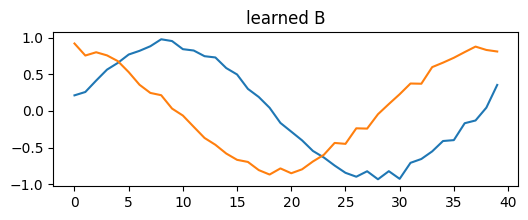

In [51]:
plt.figure(figsize=(6,2))
plt.plot(hier_rrr_B[0].T)
plt.title("learned B")
plt.show()

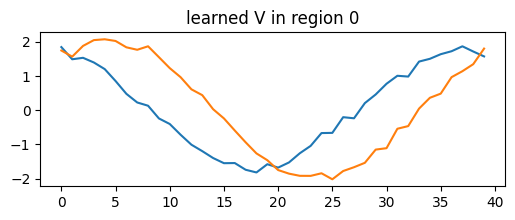

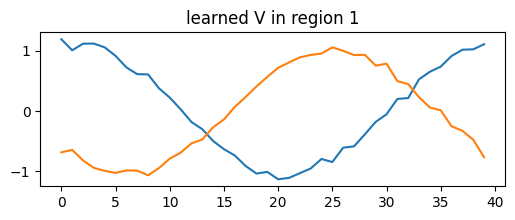

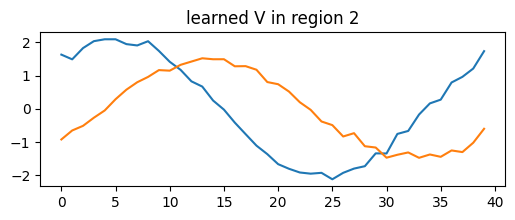

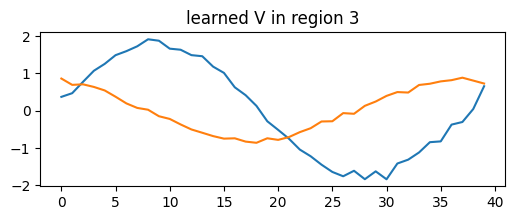

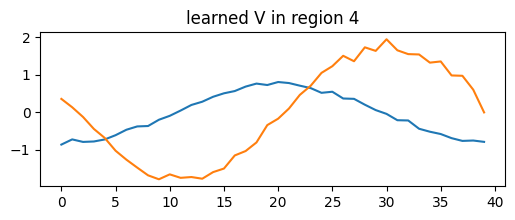

In [52]:
for i in range(n_roi):
    plt.figure(figsize=(6,2))
    plt.plot(hier_rrr.Vs[i].detach().numpy().T)
    plt.title(f"learned V in region {i}");